# Exercise 3

Let $x = ( x_0, \dots, x_{n+1} )$ with $-1=x_0<\ldots<x_{n+1}=1$ be a discrete grid for $\Omega=(-1,1)$.
We define the hat functions $\phi_i$ for $i \in \{ 1,\dots, n\}$ on this grid as follows (also see Example III.25 in the script):

$$
\phi_i(x) := 
\left\{ \begin{array}{lcl}
	\frac{x - x_{i-1}}{x_{i} - x_{i-1} }& \qquad  & \text{for } x \in [x_{i-1}, x_{i}), \\
	1 - \frac{x - x_{i}}{x_{i+1} - x_{1}}& \qquad  & \text{for } x \in [x_{i}, x_{i+1}), \\
	0 & \qquad & \text{otherwise}.
\end{array} \right.
$$

Define the finite-dimensional function space $V_n=\text{span}\{\phi_1,\dots,\phi_n\}$:
we aim to solve the Poisson equation with Dirichlet boundary conditions with a Galerkin method, using $V_n$ both as trial and test space.
More precisely:

\begin{equation}
	\left\{ \begin{array}{c}
		-u''=f  \qquad \text{in }\Omega, \\
		u(-1)=u(1)=0.
	\end{array} \right.
\end{equation}

Assume that the exact solution is $u(x) := x ^ 2 \sin( 2 \pi x )$: then we will also have
$$
f (x) = ( 4 \pi ^2 x^ 2 - 2 ) \sin( 2 \pi x ) - 8 \pi x \cos( 2 \pi x ).
$$

### a)

Create a function ```get_phi``` that takes the grid $x\in\mathbb{R}^{n+2}$ and $i \in \{ 1,\dots,n \} $ as input and returns a function (or function handle), that maps an arbitrary array $y = (y_1,\dots, y_{m}) \in\mathbb{R}^m$ to the evaluated function $( \phi_{i}(y_1) , \dots, \phi_{i}(y_m) )\in\mathbb{R}^n$. Implement this function without using loops! Then plot the obtained functions in a single figure, defining $x$ both as an uniform grid and as the Chebyshev grid (see homework sheet 5 for the definition), in both cases with $n=10$. For the purpose of plotting, use a grid with $m=1000$ equidistant points.

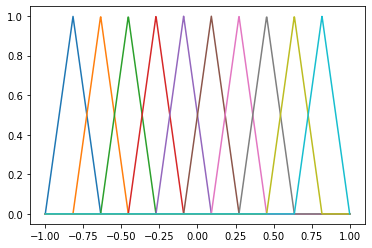

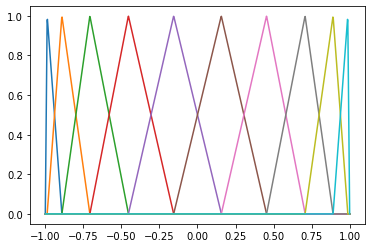

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.integrate import fixed_quad, quad
from scipy.special import roots_legendre

def chebyshev_nodes( n ):
    t = (2 * np.arange( n -2 ) + 1 ) / ( 2 * ( n -2 ) ) * np.pi     
    return np.hstack( ( -1, -np.cos(t), 1 ) )

def get_phi(grid, i ):
    assert i <= grid.shape[0] -2 
    
    def phi(y):
        
        # I use an if-else structure to avoid the error caused by integer or float input.
        # This means the function phi(y) also works when y is an integer or float.
        
        if isinstance (y,int) or isinstance (y,float):   
            if (y >= grid[i-1]) & (y <  grid[i] ):
                phi_y = ( y - grid[i-1] ) / ( grid[i] - grid[i-1] )
            elif (y >=  grid[i] ) & (y < grid[i+1]):
                phi_y = 1 - ( y - grid[i] ) / ( grid[i+1] - grid[i] )
            else: 
                phi_y = 0
        else:
            phi_y = np.zeros( len(y) )

            index_non0_1 = np.where( (y >= grid[i-1]) & (y <  grid[i] ) )  # non_zero part 1
            index_non0_2 = np.where( (y >=  grid[i] ) & (y < grid[i+1]) )  # non_zero part 2
        
            phi_y[index_non0_1] = ( y[index_non0_1] - grid[i-1] ) / ( grid[i] - grid[i-1] )
            phi_y[index_non0_2] = 1 - ( y[index_non0_2] - grid[i] ) / ( grid[i+1] - grid[i] )
                      
        return phi_y
    
    return phi

n = 10
x_plot = np.linspace(-1,1,1000)

for grid in [ np.linspace(-1,1, n + 2), chebyshev_nodes(n + 2) ]:
    fig,ax = plt.subplots()    
    for i in range(n):
        phi = get_phi(grid,i+1)
        ax.plot( x_plot , phi(x_plot) )

### b)

Create a function ```get_v``` that takes the grid $x\in\mathbb{R}^{n+2}$ and a coefficient vector $\alpha\in\mathbb{R}^n$ representing a function $v=\sum_{i=1}^n\alpha_i\phi_i\in V$ as input, and returns a callable function (or function handle) representing $v$, that similarly as before maps $y\mapsto v(y)$ for any array $y\in\mathbb{R}^m$. 
	
<b>Hint:</b> You can implement ```get_v``` more efficiently using ```numpy.searchsorted``` (this method runs in $\mathcal{O}(n)$). This is a suggestion, but it is not required.

In [12]:
def get_v(grid, coeff ):
    
    def v(y):
        
        v_list = np.zeros( len(y) )
        
        for i in range( len(coeff) ):
            phi = get_phi(grid,i+1)
            v_list += phi(y) * coeff[i]
            
        return v_list
    
    return v


### c)

Write a function ```get_A``` that assembles the Galerkin matrix $A=[a(\phi_i,\phi_j)]$ needed for the weak formulation of the BVP, given the grid $x\in\mathbb{R}^{n+2}$. Make sure you use an efficient representation for $A$. You can find the formula for $A$ in section (III.25) in the script.

Write then the function ```get_rhs``` that takes the grid $x\in\mathbb{R}^{n+2}$ and a function $f:\Omega\to\mathbb{R}$ as input, and returns the vector $F$ of the Galerkin problem, i.e.,
	$$
	F := \begin{bmatrix}
		\int_{-1}^1 f(x) \phi_1(x) \; d x \\
		\vdots \\
		\int_{-1 }^1 f(x) \phi_n(x) \; d x \\
	\end{bmatrix} \in \mathbb{R}^{n}
	$$
Write also a function ```get_un``` that takes as input a grid $x\in\mathbb{R}^{n+2}$ and a function $f:\Omega\to\mathbb{R}$, and returns the associated solution of the Galerkin problem $u_n\in V$ as a function (or function handle). 

Finally, approximate the solution of the BVP using both an uniform grid and the Chebyshev nodes with $n=20$.
Plot the two approximations together with the exact solution $u$ on the same figure.
	
<b>Hint:</b> You can approximate the integral numerically by calling one of the functions ```scipy.integrate.quad``` or ```scipy.integrate.fixed_quad``` in Python.
	
If you wish, you can also use Gauss-Legendre quadrature as you implemented it in the last two homework sheets (make sure you pick a sufficiently large $p$, though!). For efficient numerical integration, restrict the domain of the integral to only the relevant part. You may use loops here, but depending on the implementation you might be able to avoid them and obtain a faster code.
	
%	Then approximate the solution to the BVP while using an equidistant grid and the chebyshev nodes with $n=50$.

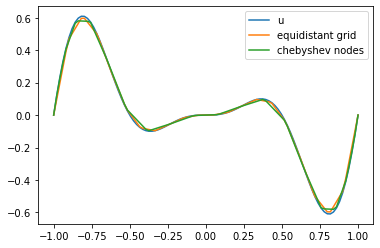

In [72]:
def f(x) :
    return 2. * ( 2. * np.pi  ** 2 *  x **  2 - 1. ) * np.sin( 2 * np.pi * x )  \
         - 8 * np.pi * x * np.cos( 2 * np.pi *  x )

def u(x):
    return x ** 2 * np.sin(2 * np.pi * x)

def get_A( grid ):
    
    main_diagonal  = [ 1/( grid[i+1]-grid[i] ) + 1/( grid[i+2]-grid[i+1] ) for i in range( len(grid)-2 ) ]   # main diagonal
    secondary_diagonal = [ -1/( grid[i+2]-grid[i+1] ) for i in range( len(grid)-3 )]                         # upper and lower diagonals
    A = diags( [main_diagonal,secondary_diagonal,secondary_diagonal],[0,1,-1] )
    
    return csr_matrix(A)

def get_rhs( grid , f ):
    
    F_list = []
    
    # I find that by using quad I cannot approximate the integral nicely when n is big, so I choose gauss-legrendre method.
    xx,ww = roots_legendre(100)  # Gauss-Legendre nodes and weights
    
    for i in range( len(grid)-2 ):
     
        phii = get_phi(grid,i+1)      # get phi
        Intg = lambda x: f(x)*phii(x) # function phi(x)*f(x)
        s = 0                         # initialize the integral 
        for j in range(100):
            s += ww[j]*Intg(xx[j])    # gauss integral
        F_list.append(s)
        
    return np.array( F_list )

def get_un( grid, f ):
    
    A_n = get_A( grid )             # the matrix A
    f_n = get_rhs( grid , f )       # the rhs f
    alpha_n = spsolve( A_n, f_n )   # solve alpha_n 
    u_n = get_v(grid, alpha_n )     # get u_n by v
    
    return u_n

n = 20
fig,ax = plt.subplots()
x_plot = np.linspace( -1, 1, 100 )
ax.plot( x_plot , u( x_plot ), label = "u")

for name, grid in [
    ( "equidistant grid", np.linspace(-1,1,n + 2)),
    ( "chebyshev nodes", chebyshev_nodes(n +2) ),
]:
    un = get_un( grid, f )
    ax.plot( x_plot , un( x_plot ), label = name)
    
ax.legend()

### d)

Solve the Galerkin problem on both the uniform and Chebyshev grids, for 20 logarithmically-spaced sizes $n=10,\ldots,10^4$. Compute the $L^2$ error (see homework sheet 10) for every instance of the problem, and plot it against $n$ in a loglog plot.

<b>Hint:</b> If your code or computer is too slow, you are allowed to adjust the maximum value of $n$ accordingly.

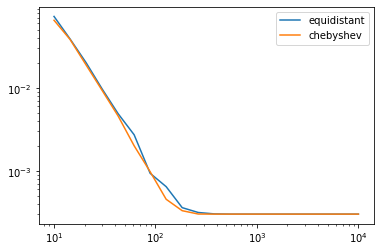

In [73]:
def error( grid , f ):

    nodes,weights = roots_legendre(50)  # Gauss-Legendre nodes and weights
    
    un = get_un( grid, f ) # Get the numerical solution u_n
    
    err = np.sqrt( sum( np.power( un(nodes)-u(nodes) , 2 ) * weights ) )  # get the error
    
    return err

ns = np.logspace(1,4, 20 )

err_eq = [ error( grid ,f ) for grid in [ np.linspace(-1,1,int(i) + 2) for i in ns ]  ]
err_cheby = [ error( grid ,f ) for grid in [ chebyshev_nodes(int(i) +2 ) for i in ns ]  ]

fig,ax = plt.subplots()
ax.loglog( ns, err_eq, label="equidistant")
ax.loglog( ns, err_cheby , label="chebyshev")
ax.legend()